# Test attention

Purpose of this notebook is to test attention mechanism on simple tasks.

In [21]:
%load_ext autoreload
%autoreload 2
from mint.model import MultiHeadAttention
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from functools import partial



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def train(model, source, target, loss, n_epochs, learning_rate):
    # simples SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = []
    for i in range(n_epochs):
        predicted = model(source, source)
        loss_val = loss(predicted, target)
        losses.append(loss_val.item())
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    return losses

def loss(source, target):
    return F.mse_loss(source, target)



Mapping: tensor([2, 9, 1, 8, 7, 0, 6, 5, 4, 3])
Source: tensor([[0, 6, 4, 0, 0, 4, 4, 8, 8, 5],
        [7, 9, 1, 9, 2, 4, 5, 3, 8, 8],
        [7, 5, 1, 5, 7, 5, 4, 3, 3, 7],
        [5, 5, 8, 6, 9, 2, 8, 2, 6, 5],
        [2, 2, 9, 1, 2, 9, 3, 7, 2, 3]])
Target: tensor([[2, 6, 7, 2, 2, 7, 7, 4, 4, 0],
        [5, 3, 9, 3, 1, 7, 0, 8, 4, 4],
        [5, 0, 9, 0, 5, 0, 7, 8, 8, 5],
        [0, 0, 4, 6, 3, 1, 4, 1, 6, 0],
        [1, 1, 3, 9, 1, 3, 8, 5, 1, 8]])
LR 0.1 Loss: 0.0020240438170731068
LR 0.01 Loss: 0.06602320075035095
LR 0.001 Loss: 0.1005895808339119


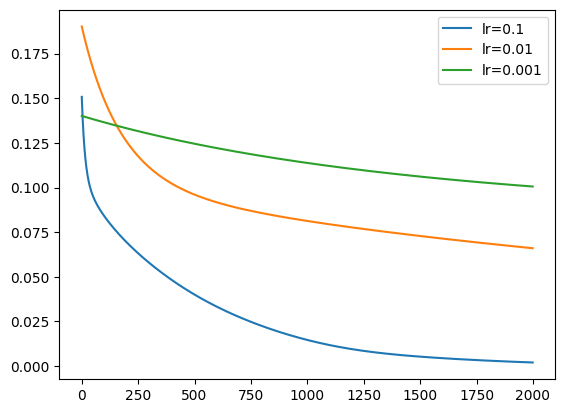

Target: tensor([[2, 6, 7, 2, 2, 7, 7, 4, 4, 0]])
Predicted: tensor([[6, 6, 7, 6, 6, 7, 7, 7, 7, 7]])


In [3]:
# Test simple 1to1 mapping
# easy task, attention focus only on single element
# loss should aproach 0

VOCAB_SIZE = 10

def generate_dataset(vocab_size, n_samples, seq_len):
    mapping = torch.randperm(vocab_size, dtype=torch.long)
    print(f"Mapping: {mapping}")

    source = torch.randint(0, VOCAB_SIZE, (n_samples, seq_len)) 
    print(f"Source: {source[:5]}")
    target = mapping[source]
    print(f"Target: {target[:5]}")

    source_embedding = F.one_hot(source, num_classes=VOCAB_SIZE).float()
    target_embedding = F.one_hot(target, num_classes=VOCAB_SIZE).float()

    return source_embedding, target_embedding



source, target = generate_dataset(VOCAB_SIZE, 10, 10)
for lr in [0.1, 0.01, 0.001]:
    attention = MultiHeadAttention(
        d_model=10,
        n_heads=1,
        max_seq_len=10,
        context_window=1
    )
    losses = train(attention, source, target, loss, 2000, lr)
    plt.plot(losses, label=f"lr={lr}")
    print(f"LR {lr} Loss: {np.mean(losses[-1])}")
plt.legend()
plt.show()

print(f"Target: {torch.argmax(target[:1], dim=-1)}")
print(f"Predicted: {torch.argmax(attention(source[:1]), dim=-1)}")




========= Causal attention | Causal context =========

Context: 1 LR 0.1 Loss: 0.014402863569557667
Source:    tensor([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]])
Target:    tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
Predicted: tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

Context: 2 LR 0.1 Loss: 0.002088122069835663
Source:    tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
Target:    tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])
Predicted: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

Context: 3 LR 0.1 Loss: 0.0048971716314554214
Source:    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
Target:    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
Predicted: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


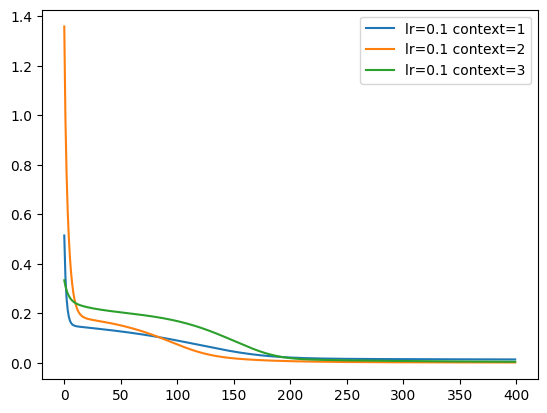

========= Causal attention | Non-causal context =========

Context: 1 LR 0.1 Loss: 0.0687246024608612
Source:    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Target:    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Predicted: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Context: 2 LR 0.1 Loss: 0.12597835063934326
Source:    tensor([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]])
Target:    tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Predicted: tensor([[0, 0, 0, 1, 1, 1, 0, 0, 1, 1]])

Context: 3 LR 0.1 Loss: 0.13021869957447052
Source:    tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
Target:    tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])
Predicted: tensor([[0, 0, 0, 1, 1, 1, 1, 0, 0, 0]])


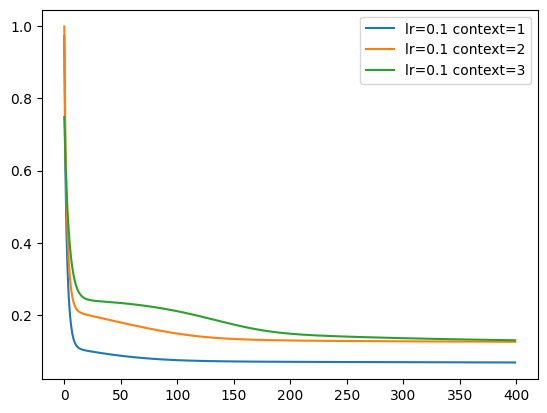

========= Non-causal attention | Non-causal context =========

Context: 1 LR 0.1 Loss: 0.007795550860464573
Source:    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
Target:    tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])
Predicted: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

Context: 2 LR 0.1 Loss: 0.009528297930955887
Source:    tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 0]])
Target:    tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Predicted: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Context: 3 LR 0.1 Loss: 0.023208245635032654
Source:    tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
Target:    tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
Predicted: tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])


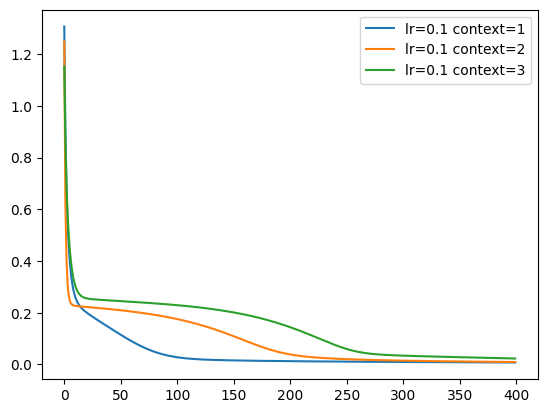

In [25]:
# test causal attention
# task is to return 1 if there is at least one 1 in previous sequence

def generate_dataset(n_samples, seq_len, context_window, causal=False):
    source = (torch.rand((n_samples, seq_len)) > 0.9).to(torch.long)
    #print(f"Source: {source[:5]}")
    
    # target is 1 if there is at least one 1 in previous `context_window` elements 
    target = torch.zeros((n_samples, seq_len), dtype=torch.long)
    for i in range(seq_len):
        upper_bound = i+1 if causal else min(seq_len, i+context_window+1)
        target[:, i] = source[:, max(0, i-context_window):upper_bound].sum(dim=-1) > 0
    #print(f"Target: {target[:5]}")
    
    
    source_embedding = F.one_hot(source, num_classes=2).float()
    target_embedding = F.one_hot(target, num_classes=2).float()

    return source_embedding, target_embedding

print("========= Causal attention | Causal context =========")
for context in range(1, 4):
    source, target = generate_dataset(10, 10, context, causal=True)
    attention = MultiHeadAttention(
        d_model=2,
        n_heads=1,
        max_seq_len=10,
        context_window=context+1,
        causal=True,
    )
    lr = 0.1
    losses = train(attention, source, target, loss, 400, lr)
    plt.plot(losses, label=f"lr={lr} context={context}")
    print(f"\nContext: {context} LR {lr} Loss: {np.mean(losses[-1])}")

    print(f"Source:    {torch.argmax(source[:1], dim=-1)}")
    print(f"Target:    {torch.argmax(target[:1], dim=-1)}")
    print(f"Predicted: {torch.argmax(attention(source[:1]), dim=-1)}")
    plt.legend()
plt.show()


# loss should be high
print("========= Causal attention | Non-causal context =========")
for context in range(1, 4):
    source, target = generate_dataset(10, 10, context, causal=False)
    attention = MultiHeadAttention(
        d_model=2,
        n_heads=1,
        max_seq_len=10,
        context_window=context+1,
        causal=True,
    )
    lr = 0.1
    losses = train(attention, source, target, loss, 400, lr)
    plt.plot(losses, label=f"lr={lr} context={context}")
    print(f"\nContext: {context} LR {lr} Loss: {np.mean(losses[-1])}")

    print(f"Source:    {torch.argmax(source[:1], dim=-1)}")
    print(f"Target:    {torch.argmax(target[:1], dim=-1)}")
    print(f"Predicted: {torch.argmax(attention(source[:1]), dim=-1)}")
    plt.legend()
plt.show()


print("========= Non-causal attention | Non-causal context =========")
for context in range(1, 4):
    source, target = generate_dataset(10, 10, context, causal=False)
    attention = MultiHeadAttention(
        d_model=2,
        n_heads=1,
        max_seq_len=10,
        context_window=context+1,
        causal=False,
    )
    lr = 0.1
    losses = train(attention, source, target, loss, 400, lr)
    plt.plot(losses, label=f"lr={lr} context={context}")
    print(f"\nContext: {context} LR {lr} Loss: {np.mean(losses[-1])}")

    print(f"Source:    {torch.argmax(source[:1], dim=-1)}")
    print(f"Target:    {torch.argmax(target[:1], dim=-1)}")
    print(f"Predicted: {torch.argmax(attention(source[:1]), dim=-1)}")
    plt.legend()
plt.show()
